## Analysis of flight delays and taxiing times and its relationship to the local weather for Jan 2018

In this notebook, I am experimenting with combining data from different sources to find correlations between relevant parameters and experimenting with creating interactive plots using Bokeh.  The data and the correponding data sources used in this analysis are

* Flight details are obtained from [On-Time Flight performance database](https://www.transtats.bts.gov/DL_SelectFields.asp?DB_Short_Name=On-Time&Table_ID=236)
* Airline details are obtained from [Carrier Decode Table](https://www.transtats.bts.gov/Tables.asp?DB_ID=595&DB_Name=Aviation%20Support%20Tables&DB_Short_Name=Aviation%20Support%20Tables#)
* Airport information (including precise location) is obtained from [Master Coordinate Table](https://www.transtats.bts.gov/Tables.asp?DB_ID=595&DB_Name=Aviation%20Support%20Tables&DB_Short_Name=Aviation%20Support%20Tables#)
* Daily average weather conditions are obtained from [National Climatic Data Center (NCDC)](ftp://ftp.ncdc.noaa.gov/pub/data/gsod)
* Information (including precise location) about weather stations are obtained from [Station list](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt)

All data presented here only correspond to airports within the US for the month of January 2018.  Data for other time periods (month, year) are availabe at the sites mentioned above.  Similar analysis could be applied to those other time periods by downloading the appropriate data sets.  But, that is beyond the scope of this analysis.

#### (For now, I am not including any weather related plots.  These will be added later).

In [2]:
#######################################################################
#  Import required libraries and Delete all pre-defined variables
#######################################################################
import numpy as Numpy
import matplotlib.pyplot as Plt
%matplotlib inline
import math as Math
#import time as Time
#import ftplib as Ftplib
#import pickle as Pickle
import os as Os
import datetime as DateTime
import pandas as Pandas

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

In [3]:
#######################################################################
# Import spark libraries
#######################################################################
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql import functions as F

In [4]:
#######################################################################
# Print Python and matplotlib versions
#######################################################################
import sys
print('Python version is: %s.%s.%s' % (sys.version_info[0], sys.version_info[2], sys.version_info[2]))
#
import matplotlib as Matplotlib
print('matplotlib version is: {}'.format(Matplotlib.__version__))

Python version is: 3.2.2
matplotlib version is: 1.5.3

In [5]:
#######################################################################
# Initialize Spark and SQLcontexts
#######################################################################
try:
    sc
except NameError:
    print('No SparkContext exist..')
else:
    print('SparkContext already exists..')

try:
    sql
except NameError: 
    print('SQLcontext does not exist..')
else:
    print('SQLcontext already exists..')
    
#sc.stop()
#sc = SparkContext(master="local[4]")
sql = SQLContext(sc)

SparkContext already exists..
SQLcontext already exists..

In [6]:
#######################################################################
# User Input
#######################################################################
dataDir = '/FileStore/tables/'
fileID = '049e5'
yyyymmOfInt = '201801'
flightFile = 'Flight_onTime_' + yyyymmOfInt
yearOfInt = yyyymmOfInt[0:4]
airpID = '1129202'
flightCols = ['Day', 'Date', 'CAR', 'FLNum', 'ORIGIN_ID', 'DEST_ID',  
                  'DEP_SCH', 'DEP_DEL', 'DEP_TAXI', 
                  'ARR_TAXI', 'ARR_SCH', 'ARR_DEL', 'CANCEL']
#yyyy_mm_OfInt = f'{yyyymmOfInt[0:4]}-{yyyymmOfInt[4:6]}'
yyyy_mm_OfInt = "%s-%s" % (yyyymmOfInt[0:4], yyyymmOfInt[4:6])

In [7]:
#######################################################################
# unzip the data file, read the data file in to a Spark DataFrame, and 
# zip it back up again
# /FileStore/tables/Flight_onTime_201801_csv-049e5.gz
#######################################################################
#unzipCmd = f'gunzip -f {dataDir}{flightFile}_csv-{fileID}.gz'
#renCmd = f'mv -f {dataDir}{flightFile}_csv-{fileID} {dataDir}{flightFile}.csv'
#renCmd1 = f'mv -f {dataDir}{flightFile}.csv {dataDir}{flightFile}_csv-{fileID}'
#zipCmd = f'gzip -f {dataDir}{flightFile}_csv-{fileID}'
#unzipCmd = 'gunzip -f %s%s_csv-%s.gz' % (dataDir, flightFile, fileID)
#renCmd = 'mv -f %s%s_csv-%s %s%s.csv' % (dataDir, flightFile, fileID, dataDir, flightFile)
#renCmd1 = f'mv -f {dataDir}{flightFile}.csv {dataDir}{flightFile}_csv-{fileID}'
#zipCmd = f'gzip -f {dataDir}{flightFile}_csv-{fileID}'
#!$unzipCmd
#!$renCmd
allData = (sql.read.format("com.databricks.spark.csv")
         .option("header", "true")
         #.load(f'{dataDir}{flightFile}.csv'))
         .load('%s%s.csv' % (dataDir, flightFile)))

In [8]:
#######################################################################
# Drop extraneous column at the end, rename columns, remove na data, rearrange
# all data
#rearrData2 = (cleanData
#             .select(['Day', 'Date', 'CAR', 'ORIGIN_ID', 'CANCEL'])
#             .withColumnRenamed('CANCEL', 'FLAG')
#             .withColumnRenamed('ORIGIN_ID', 'AIRPORT_ID')
#             .withColumn('TYPE', lit('DEP_CANCEL'))
#             .union(cleanData
#                    .select(['Day', 'Date', 'CAR', 'DEST_ID', 'CANCEL'])
#                    .withColumnRenamed('CANCEL', 'FLAG')
#                    .withColumnRenamed('DEST_ID', 'AIRPORT_ID')
#                    .withColumn('TYPE', lit('ARR_CANCEL')))
#            )
#######################################################################
cleanData = (allData
             .drop('_c13')
             .toDF(*flightCols)
             .dropna(how='any',
                     subset=['DEP_DEL', 'ARR_DEL', 'DEP_TAXI', 'ARR_TAXI'])
            ).cache()
             
rearrData = (cleanData
             .select(['Day', 'Date', 'CAR', 'ORIGIN_ID', 'DEP_DEL'])
             .withColumnRenamed('DEP_DEL', 'DURATION')
             .withColumnRenamed('ORIGIN_ID', 'AIRPORT_ID')
             .withColumn('TYPE', lit('DEP_DEL'))
             .union(cleanData
                    .select(['Day', 'Date', 'CAR', 'DEST_ID', 'ARR_DEL'])
                    .withColumnRenamed('ARR_DEL', 'DURATION')
                    .withColumnRenamed('DEST_ID', 'AIRPORT_ID')
                    .withColumn('TYPE', lit('ARR_DEL')))
             .union(cleanData
                    .select(['Day', 'Date', 'CAR', 'ORIGIN_ID', 'DEP_TAXI'])
                    .withColumnRenamed('DEP_TAXI', 'DURATION')
                    .withColumnRenamed('ORIGIN_ID', 'AIRPORT_ID')
                    .withColumn('TYPE', lit('DEP_TAXI')))
             .union(cleanData
                    .select(['Day', 'Date', 'CAR', 'DEST_ID', 'ARR_TAXI'])
                    .withColumnRenamed('ARR_TAXI', 'DURATION')
                    .withColumnRenamed('DEST_ID', 'AIRPORT_ID')
                    .withColumn('TYPE', lit('ARR_TAXI')))
            ).cache()

#print(allData.count(), cleanData.count(), rearrData.cache().count())
#print(allData.printSchema())

In [9]:
#######################################################################
# Compute stats on the data - imperatively (using sparkSQL functions)
#######################################################################
statsAll = (rearrData
              .groupby(['Date', 'CAR', 'AIRPORT_ID', 'TYPE'])
              .agg(F.round(F.mean(F.col('DURATION')), 1).alias('mean'),
                   F.round(F.stddev(F.col('DURATION')), 1).alias('stdev'),
                  F.count(F.col('DURATION')).alias('count'))
              .union(rearrData
                    .groupby(['CAR', 'AIRPORT_ID', 'TYPE'])
                    .agg(F.round(F.mean(F.col('DURATION')), 1).alias('mean'),
                         F.round(F.stddev(F.col('DURATION')), 1).alias('stdev'),
                         F.count(F.col('DURATION')).alias('count'))
                    .withColumn('Date',F.lit(yyyy_mm_OfInt))
                    .select(['Date', 'CAR', 'AIRPORT_ID', 'TYPE', 'mean', 'stdev', 'count'])
                    )
              .union(rearrData
                    .groupby(['Date', 'AIRPORT_ID', 'TYPE'])
                    .agg(F.round(F.mean(F.col('DURATION')), 1).alias('mean'),
                         F.round(F.stddev(F.col('DURATION')), 1).alias('stdev'),
                         F.count(F.col('DURATION')).alias('count'))
                    .withColumn('CAR',F.lit('All'))
                    .select(['Date', 'CAR', 'AIRPORT_ID', 'TYPE', 'mean', 'stdev', 'count'])
                    )
              .union(rearrData
                    .groupby(['AIRPORT_ID', 'TYPE'])
                    .agg(F.round(F.mean(F.col('DURATION')), 1).alias('mean'),
                         F.round(F.stddev(F.col('DURATION')), 1).alias('stdev'),
                         F.count(F.col('DURATION')).alias('count'))
                    .withColumn('CAR',F.lit('All'))
                    .withColumn('Date',F.lit(yyyy_mm_OfInt))
                    .select(['Date', 'CAR', 'AIRPORT_ID', 'TYPE', 'mean', 'stdev', 'count'])
                    )
             )

#statsAll.show(5)
#print(type(statsByDay))

In [10]:
#######################################################################
# Compute stats on the data using SQL
#######################################################################
sql.registerDataFrameAsTable(rearrData, 'rearrDataTable')
query = """
SELECT
    *
from
    (
    SELECT 
        Date, CAR, AIRPORT_ID, TYPE, 
        round(mean(DURATION), 1) as mean,
        round(std(DURATION), 2) as std,
        count(DURATION) as count
    FROM
        rearrDataTable
    GROUP BY
        Date, CAR, AIRPORT_ID, TYPE
    )
    UNION ALL
    (
    SELECT 
        Date, 'All' as CAR, AIRPORT_ID, TYPE, 
        round(mean(DURATION), 1) as mean,
        round(std(DURATION), 2) as std,
        count(DURATION) as count
    FROM
        rearrDataTable
    GROUP BY
        Date, AIRPORT_ID, TYPE    
    )    
    UNION ALL
    (
    SELECT 
        '%s' as Date, CAR, AIRPORT_ID, TYPE, 
        round(mean(DURATION), 1) as mean,
        round(std(DURATION), 2) as std,
        count(DURATION) as count
    FROM
        rearrDataTable
    GROUP BY
        CAR, AIRPORT_ID, TYPE    
    )
    UNION ALL
    (
    SELECT 
        '%s' as Date, 'All' AS CAR, AIRPORT_ID, TYPE, 
        round(mean(DURATION), 1) as mean,
        round(std(DURATION), 2) as std,
        count(DURATION) as count
    FROM
        rearrDataTable
    GROUP BY
        AIRPORT_ID, TYPE    
    )
"""%(yyyy_mm_OfInt, yyyy_mm_OfInt)
#print(query)
allStatsSQL = sql.sql(query)
#allStatsSQL.show(5)

In [11]:
#######################################################################
# A simple plot of the mean values for all airlines for a specific 
# airport(given by airpID)
# Only include those airlines that whose monthly flights were more than
# 0.5% of that of the airport.
#######################################################################
%time
statsAirp = allStatsSQL.filter(F.col('AIRPORT_ID')==airpID)
statsAirpM = (statsAirp
                .filter((F.col('Date')==yyyy_mm_OfInt) & (F.col('CAR')=='All'))
                .orderBy(F.col('TYPE'), F.col('count').desc())
                .withColumnRenamed('count', 'AirpMTot')
                .withColumnRenamed('mean', 'AirpMmean')
                .withColumnRenamed('std', 'AirpMstd')
                .drop('Date', 'CAR')
                )
statsAirpD = (statsAirp
                .filter((F.col('Date')!=yyyy_mm_OfInt) & (F.col('CAR')=='All'))
                .orderBy(F.col('TYPE'), F.col('count').desc())
                .withColumnRenamed('count', 'AirpDTot')
                .withColumnRenamed('mean', 'AirpDmean')
                .withColumnRenamed('std', 'AirpDstd')
                .drop('CAR')
                )
statsAirlM = (statsAirp
                .filter((F.col('Date')==yyyy_mm_OfInt) & (F.col('CAR')!='All'))
                .join(statsAirpM, ['AIRPORT_ID', 'TYPE'], 'inner')
                .filter(F.col('count')>0.005*F.col('AirpMTot'))
                .drop('Date')
                .withColumnRenamed('count','AirlMTot')
                .withColumnRenamed('mean','AirlMmean')
                .withColumnRenamed('std','AirlMstd')
                .orderBy(F.col('TYPE').desc(), F.col('AirlMTot').desc())
               )
statsDate = (statsAirp
                .filter((F.col('Date')!=yyyy_mm_OfInt) & (F.col('CAR')!='All'))
                .join(statsAirlM, ['AIRPORT_ID', 'TYPE', 'CAR'], 'inner')
                .join(statsAirpD, ['Date', 'AIRPORT_ID', 'TYPE'], 'inner')
                .orderBy(F.col('TYPE').desc(), F.col('Date'), F.col('AirlMTot').desc())
            )
#print(allStatsSQL.count(), 
#      statsAirpM.count(), 
#      statsAirpD.count(), 
#      statsAirlM.count(),
#     statsDate.count())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs

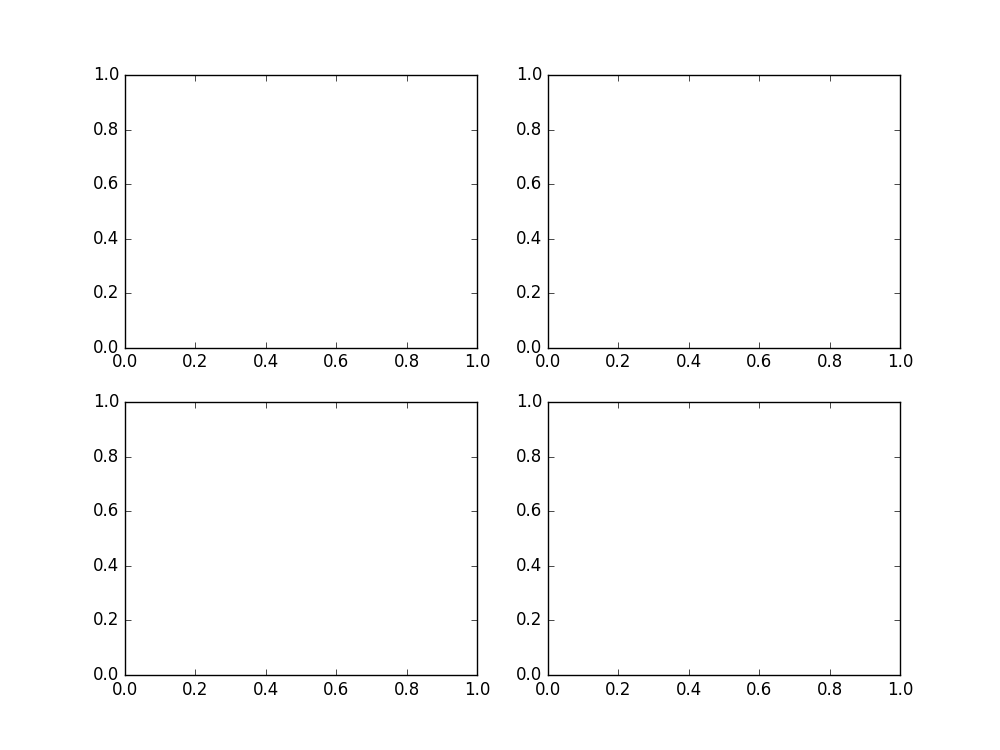

In [12]:
#######################################################################
#  Commented out the following plots since categorical x-axis is not
#  supported by the old matplotlib version that is present in the 
#  Databricks CE image.  If this notebook was run on a system that
#  supports newer versions of matplotlib (2.1.0 or later), the following
#  could be uncommented. 
#######################################################################
statsAirlMdf = statsAirlM.toPandas()
fig1 = Plt.figure(1,figsize=(10,7.5))
fig1.clf()
i = 0
for type in list(statsAirlMdf['TYPE'].unique()):
    i = i + 1
    print(type)
    ax = fig1.add_subplot(2,2,i)
    #ax.line(statsAirlMdf[statsAirlMdf['TYPE']==type]['CAR'], 
    #           statsAirlMdf[statsAirlMdf['TYPE']==type]['AirlMmean'], 
    #           label='mean')
    #ax.line(statsAirlMdf[statsAirlMdf['TYPE']==type]['CAR'], 
    #           statsAirlMdf[statsAirlMdf['TYPE']==type]['AirlMstd'], 
    #           label='std')
    #ax.legend(loc='upper right')
    #ax.legend(loc='upper center')
    #ax.set_ylabel('mins', fontsize=14)
    
    #ax1 = ax.twinx()    
    #ax1.bar(statsAirlMdf[statsAirlMdf['TYPE']==type]['CAR'], 
    #           statsAirlMdf[statsAirlMdf['TYPE']==type]['AirlMTot'],
    #           label='Total', alpha=1.0)
    #ax1.set_xlabel('Airline', fontsize=14)
    #ax1.set_ylabel('Monthly Total', fontsize=14)

    #Plt.xticks(rotation=90)
    #Plt.title(type, fontsize=18)
    
#fig1.tight_layout()
#fig1.suptitle(airpID, fontsize=24)
display(fig1)
fig1.savefig('/dbfs/tmp/monthlyStats.png', dpi=600)
dbutils.fs.mkdirs("/FileStore/anand/")
dbutils.fs.rm("/FileStore/anand/monthlyStats.png")
dbutils.fs.cp("file:/dbfs/tmp/monthlyStats.png", "/FileStore/anand/monthlyStats.png")

In [13]:
%fs ls /FileStore/anand

path,name,size
dbfs:/FileStore/anand/monthlyStats.png,monthlyStats.png,233123


In [14]:
#!$renCmd1
#!$zipCmd